In [4]:
# Read data and EDA
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

# Preparation and Evaluation
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split

# Model Implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout,Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [5]:
train_data = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
train_data = train_data.rename(columns={'label': 'generated', 'prompt_name': 'prompt_id'}, errors='ignore')
train_data

,text,generated,prompt_id,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [6]:
test_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [7]:
sample_sub = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


data preprocessing

In [8]:
human_gen_from_comp = train_data.query('source == "train_essays"').query('generated == 0')
all_other = train_data.query('source != "train_essays"')
print(human_gen_from_comp.shape)
print(all_other.shape)

(1375, 5)
(43490, 5)


In [9]:
chars_from_comp_human = set(list(''.join(human_gen_from_comp.text.to_list())))

In [10]:
chars_from_other = set(list(''.join(all_other.text.to_list())))

In [11]:
chars_to_remove = ''.join([x for x in chars_from_other if x not in chars_from_comp_human])
print(chars_to_remove)

👫”力🏔。💅🌳⏰🏽🕺ºり🌧驾□🕹う🚌Ã️止✨😩🇺ã🛸🧑📦📝👨💦😝💉💨🌻😋所’🎥🚔🏡🙏🧦🤒🍋🎵а👌🏖‘²🐧😨💁🏯📰🍞🐕​完🤖🌎🎭~あ者👂😊💭🌠¢🤟🙅🏥🤛–�🥶¶🚪🎹集🚴🕰🎠пó意😌🐸👧🥳ê🥘þ👦🍭🤤`¨<💆🐰🌸·🌃🚣😷🌄🌽🍟道🎨👮®*🤘🦄 😄🌯🧚将📈ü合🌱🥑み🐟🎃🔋…🥛🇸🙃👥司👕🤣🎾🍁🚭部🥜🗣一ä—🤕🤜😤💜Å应🛑🌮á上}🥪👍🚗🏫🏀💻🍜驶🔑🐶🍰🤫🐻📄🥭注时🥔Â🏳👯💫😖🙊😔😮🚂🧖💥🚕^е🍄😬🇫🐆选🏢🌞🎄🔜©🥩😁ï🌐é🍣🌈😵¡🚀🛬🔥🍖🙄😂💪🏙´は📅🥲🐭🤔🏠🎊🎯🤩+取机🧙🐬す🥤用📊🏨🎸Ö💚有😕😃=🤦⚽🏃🇵🤓🍴💡💇;🐝🌌🥕在😱📣💼@😅ち🎩🔍­💊🎤🍝♂📺🏏👏💘/💀📖☀)ん🧡🎧🙌🕒🍓¹🌊🕵😳都🙀🛀🎅🍲🧹{😓🛣🐾🌿😜🇯に🍳😒🛠中😭🥖🏼£🎶😆🚚🌫🚫🏦å🧘‍🏈🥨的保🎈📧🔧😹📹📉が🚨👋🐱😴─🌭择🌏👪手з🥦🧐ま💰必(和Ó🏄こ🌨#«♀💯🐒🏛🦁禁🐳🍮响🥁🛫🏕📚🏟🥟😲🧩须🧀â🤷🤞安🏋使🤝😠☹🍕🦎🇪д👬🎓影


In [12]:
translation_map = str.maketrans('', '', chars_to_remove)
def remove_chars(s):
    return s.translate(translation_map)
all_other.loc[:, 'text'] = all_other.loc[:, 'text'].apply(remove_chars)

In [13]:
train_updated = pd.concat([human_gen_from_comp, all_other]).sample(frac=1, random_state=42).reset_index(drop=True)
train_updated['source'].value_counts()

source
persuade_corpus                       25996
llama2_chat                            2421
mistral7binstruct_v1                   2421
chat_gpt_moth                          2421
mistral7binstruct_v2                   2421
kingki19_palm                          1384
train_essays                           1375
llama_70b_v1                           1172
falcon_180b_v1                         1055
darragh_claude_v6                      1000
darragh_claude_v7                      1000
radek_500                               500
NousResearch/Llama-2-7b-chat-hf         400
mistralai/Mistral-7B-Instruct-v0.1      400
cohere-command                          350
palm-text-bison1                        349
radekgpt4                               200
Name: count, dtype: int64

EDA

In [14]:
train_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44865 entries, 0 to 44864
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44865 non-null  object
 1   generated      44865 non-null  int64 
 2   prompt_id      44865 non-null  object
 3   source         44865 non-null  object
 4   RDizzl3_seven  44865 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [15]:
train_updated.head(10)

,text,generated,prompt_id,source,RDizzl3_seven
0,"Hey, so like, technology has totally changed t...",1,Distance learning,llama2_chat,False
1,Studying Venus is a great idea. We study Venus...,0,Exploring Venus,persuade_corpus,True
2,working on a group project\n\nWorking in a gro...,1,Distance learning,mistral7binstruct_v1,False
3,Peple think that the only way of transportatio...,0,Car-free cities,persuade_corpus,True
4,Dear Principal\n\nI think we should be aloud t...,0,Cell phones at school,persuade_corpus,False
5,A decline in the use of motor vehicles would g...,0,Car-free cities,persuade_corpus,True
6,People all over the world love to do extracurr...,0,Mandatory extracurricular activities,persuade_corpus,False
7,"Hey there! \n\nSo, you wanna know about the be...",1,Distance learning,llama2_chat,False
8,"Dear principle,\n\nYou should require all stud...",0,Community service,persuade_corpus,False
9,I disagree with the decision made by our princ...,1,Mandatory extracurricular activities,llama_70b_v1,False


In [16]:
train_updated.describe()

,generated
count,44865.000000
mean,0.389925
std,0.487739
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


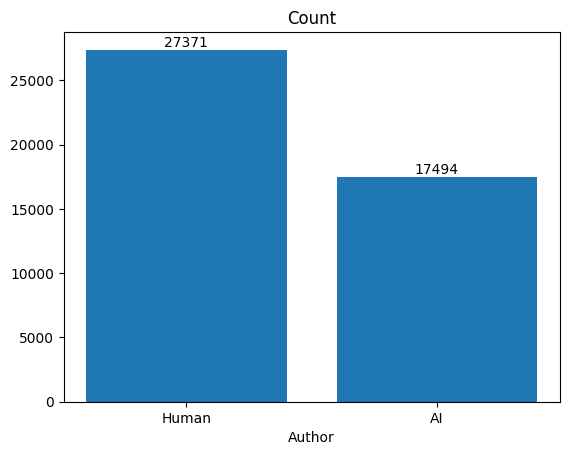

In [17]:
human_ai_count = train_updated['generated'].value_counts().reset_index()
human_ai_count['generated'] = human_ai_count['generated'].replace({0: 'Human', 1: 'AI'})
plt.bar(human_ai_count['generated'], human_ai_count['count'])
plt.xlabel('Author')
plt.title(f'Count')
[plt.text(lbl, count, count, ha="center", va="bottom") for (lbl, count) in human_ai_count.to_numpy()]
plt.show()

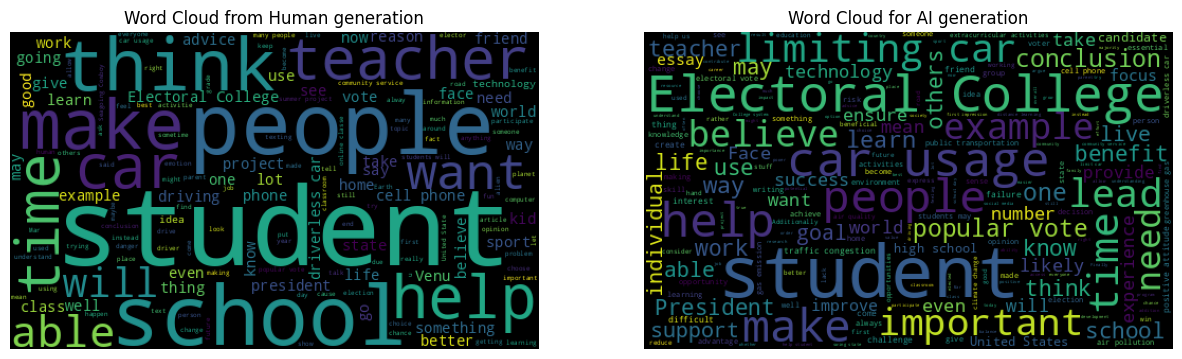

In [18]:
# Convert all articles into single string
word_cloud_0 = train_updated.query('generated == 0')['text'].str.cat(sep=" ")
word_cloud_0 = WordCloud(width=500, height=300).generate(word_cloud_0)
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(word_cloud_0)
plt.title('Word Cloud from Human generation')
plt.axis("off")

plt.subplot(1, 2, 2)
word_cloud_1 = train_updated.query('generated == 1')['text'].str.cat(sep=" ")
word_cloud_1 = WordCloud(width=500, height=300).generate(word_cloud_1)
plt.imshow(word_cloud_1)
plt.title('Word Cloud for AI generation')
plt.axis("off")

plt.show()

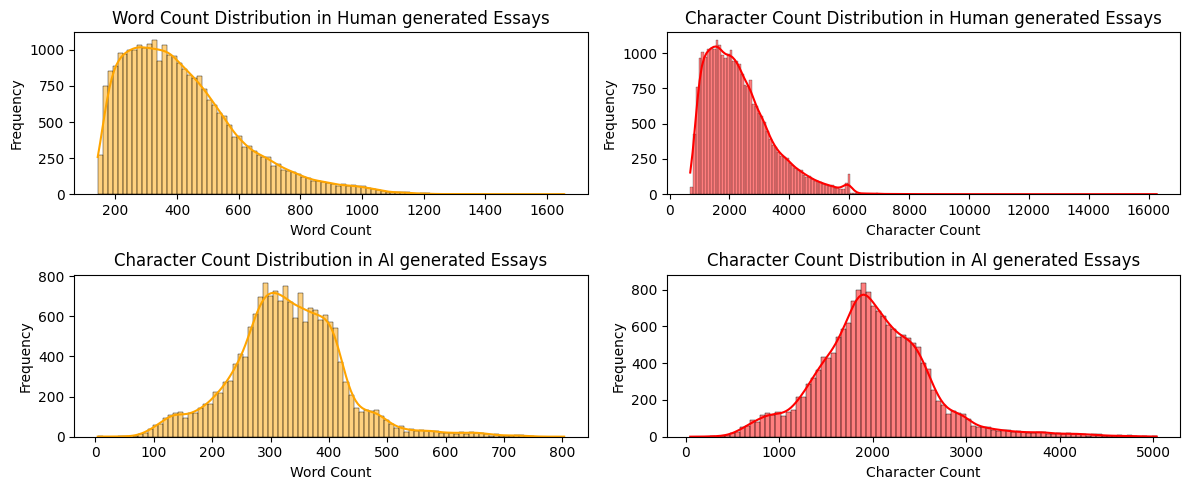

In [19]:
def show_hist_plot(series, title, xlabel, ylabel, color):
    sns.histplot(series, kde=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

train_updated['word_count'] = train_updated['text'].apply(lambda x: len(x.split()))
train_updated['char_count'] = train_updated['text'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
show_hist_plot(train_updated.query('generated == 0')['word_count'], 'Word Count Distribution in Human generated Essays', 'Word Count', 'Frequency', 'orange')

plt.subplot(2, 2, 2)
show_hist_plot(train_updated.query('generated == 0')['char_count'], 'Character Count Distribution in Human generated Essays', 'Character Count', 'Frequency', 'red')

plt.subplot(2, 2, 3)
show_hist_plot(train_updated.query('generated == 1')['word_count'], 'Character Count Distribution in AI generated Essays', 'Word Count', 'Frequency', 'orange')

plt.subplot(2, 2, 4)
show_hist_plot(train_updated.query('generated == 1')['char_count'], 'Character Count Distribution in AI generated Essays', 'Character Count', 'Frequency', 'red')

plt.tight_layout()
plt.show()

Data Split 

In [20]:
x_train, x_val, y_train, y_val = train_test_split(train_updated['text'], train_updated['generated'], test_size=0.2, shuffle=True)

In [21]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(35892,)
(8973,)
(35892,)
(8973,)


In [22]:
all_train_words = []
for s in x_train:
    all_train_words.extend(s.split())
all_train_words = np.unique(all_train_words)
len(all_train_words)

155337

Word Embedding

In [23]:
max_words = 6000
print(max_words)
x_train_np = x_train.values
x_val_np = x_val.values
tk = Tokenizer(num_words=max_words, oov_token="OOV")
tk.fit_on_texts(x_train_np)

x_train_seq = tk.texts_to_sequences(x_train_np)
x_val_seq = tk.texts_to_sequences(x_val_np)
print(len(x_train_seq))

6000
35892


In [24]:
print("Max length of text:", max([len(seq) for seq in x_train_seq]))
print("Min length of text:", min([len(seq) for seq in x_train_seq]))

Max length of text: 1656
Min length of text: 5


In [25]:
# max_len = max([len(seq) for seq in x_train_seq])
# max_len = int(np.ceil(max_len / 100) * 100)
max_len = 1000
x_train_padded = pad_sequences(x_train_seq, maxlen=max_len, padding="post", truncating="post")
x_val_padded = pad_sequences(x_val_seq, maxlen=max_len, padding="post", truncating="post")
print(x_train_padded.shape)
print(x_val_padded.shape)

(35892, 1000)
(8973, 1000)


In [26]:
y_train_np = y_train.values
y_val_np = y_val.values

Bi-LSTM

In [59]:
from tensorflow.keras.layers import LSTM

def bi_lstm_model(max_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=1000, input_length=max_len))
    model.add(Bidirectional(LSTM(100)))  # Using LSTM instead of SimpleRNN
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Set the maximum number of words and maximum sequence length
max_words = 6000  # This should match the number you used in your tokenizer
max_len = 1000     # This should match the length you've used for padding sequences

# Create and compile the Bi-LSTM model
model1 = bi_lstm_model(max_words, max_len)
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display the model's architecture
model1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 1000)        6000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               880800    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6901001 (26.33 MB)
Trainable params: 6901001 (26.33 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [60]:
EPOCHS = 3
BATCH_SIZE = 64
history = model1.fit(x_train_padded, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val_padded, y_val_np))

Epoch 1/3
561/561 [==============================] - 140s 242ms/step - loss: 0.1251 - accuracy: 0.9546 - val_loss: 0.0583 - val_accuracy: 0.9832
Epoch 2/3
561/561 [==============================] - 116s 206ms/step - loss: 0.0572 - accuracy: 0.9840 - val_loss: 0.0405 - val_accuracy: 0.9861
Epoch 3/3
561/561 [==============================] - 112s 199ms/step - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0.1012 - val_accuracy: 0.9750


In [61]:
loss, acc = model1.evaluate(x_val_padded, y_val_np)

281/281 [==============================] - 13s 46ms/step - loss: 0.1012 - accuracy: 0.9750


In [30]:
print("Loss on validation data is:", loss)
print("Accuracy on validation data:", acc)

Loss on validation data is: 0.06652496755123138
Accuracy on validation data: 0.9774880409240723


281/281 [==============================] - 12s 44ms/step


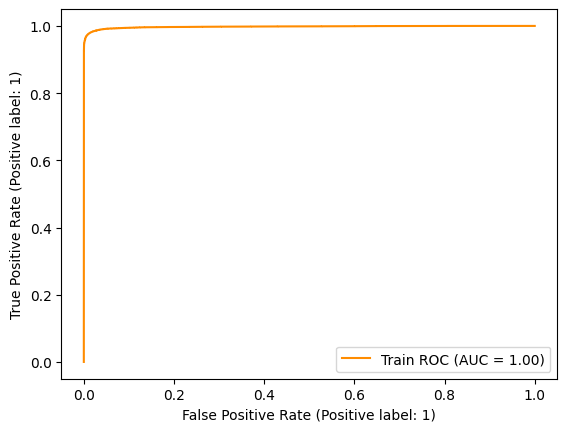

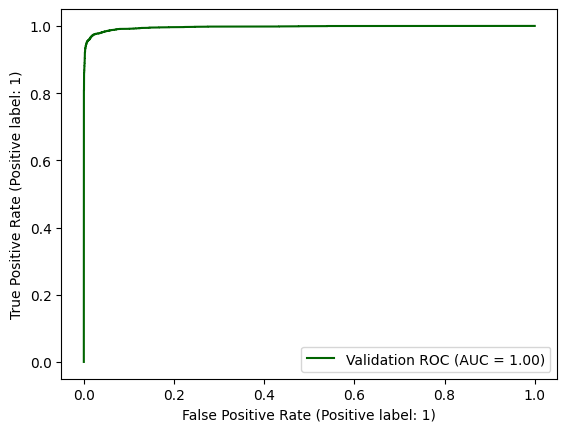

In [31]:
y_train_pred = model1.predict(x_train_padded)
y_val_pred = model1.predict(x_val_padded)

RocCurveDisplay.from_predictions(
    y_train_np,
    y_train_pred,
    name=f"Train ROC",
    color="darkorange"
)

RocCurveDisplay.from_predictions(
    y_val_np,
    y_val_pred,
    name=f"Validation ROC",
    color="darkgreen"
)

getting the output / prediction on model-1

In [32]:
# test_text_processed = text_preprocess(test_essay['text'])
test_essay.loc[:, 'text'] = test_essay.loc[:, 'text'].apply(remove_chars)
x_test_seq = tk.texts_to_sequences(test_essay['text'].values)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding="post", truncating="post")

In [33]:
x_test_padded.shape

(3, 1000)

In [62]:
y_pred = model1.predict(x_test_padded)
y_pred

1/1 [==============================] - 1s 694ms/step


array([[0.95296],
       [0.95296],
       [0.95296]], dtype=float32)

In [64]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred]})
final_submission.to_csv('submission_kag_model1.csv', index=False)

In [ ]:
model1.save('model1l.h5')


In [35]:
# ChatGPT 3.5 Generated paragraphs on prompt ID 0
gpt_text = 'In our rapidly evolving world, the convenience of personal automobiles has become deeply ingrained in our daily lives. However, it is essential to consider the broader implications of our reliance on cars, not just for individual comfort but also for the collective well-being of our society and the environment. This essay explores the advantages of limiting car usage, drawing insights from multiple sources to underscore the importance of embracing alternative transportation methods for a sustainable future.'
gpt_text_2 = 'One significant advantage of reducing car usage lies in the realm of environmental preservation. According to a report by the Environmental Protection Agency (EPA), the transportation sector is a major contributor to air pollution and greenhouse gas emissions. Cars emit pollutants that degrade air quality, leading to respiratory problems and other health issues. By limiting car usage and promoting alternatives such as public transportation, cycling, and walking, we can collectively reduce our carbon footprint and mitigate the impact of climate change.'
gpt_text_3 = 'Furthermore, limiting car usage can have profound positive effects on traffic congestion and urban planning. A study conducted by the Urban Land Institute reveals that the overreliance on cars contributes to congested roadways, leading to increased travel times and economic inefficiencies. Implementing measures to limit car usage, such as developing comprehensive public transportation systems and promoting carpooling, can alleviate traffic congestion, making cities more livable and efficient.'

# BBC news articles
bbc_text = 'Those alleged conversations were outlined in an indictment unsealed by US prosecutors on Wednesday. The US Justice Department has charged Mr Gupta with an elaborate plot to assassinate a dual US-Canadian citizen based in New York, a plot allegedly directed by an Indian government employee.'
bbc_text_1 = 'In the Paris Agreement itself, the baseline for pre-industrial measures wasn\'t defined. But the International Panel on Climate Change uses a baseline of 1850-1900. That\'s because it\'s the earliest period with reliable, near-global measurements. It\'s true that some warming from human activity had already occurred by that point, because the industrial revolution began in the early 1700s. But having good historical data for a reliable baseline is crucial to measure changes happening today.'
bbc_text_2 = 'The room bustled with the din of volunteer waitstaff and diners amid a jazzy soundtrack playing overhead. A knife suddenly clanged against the floor. No one seemed to hear it except for renowned, three-Michelin starred chef Massimo Bottura, who instinctively ran over to pick it up, gave the diner a new utensil and initiated a warm, friendly chat to ensure he was enjoying his meal. With Bottura, the patrons at this church hall are given the same level of hospitality as those at his high-end restaurants like the famed Osteria Francescana and the newly opened Al Gatto Verde in Modena, Italy.'

extra_texts = [gpt_text, gpt_text_2, gpt_text_3, bbc_text, bbc_text_1, bbc_text_2]
extra_texts = pd.DataFrame({'text': extra_texts, 'generated': [1, 1, 1, 0, 0, 0]})
extra_texts.loc[:, 'text'] = extra_texts.loc[:, 'text'].apply(remove_chars)
extra_text_seq = tk.texts_to_sequences(extra_texts['text'])
extra_text_padded = pad_sequences(extra_text_seq, maxlen=max_len, padding="post", truncating="post")
model.evaluate(extra_text_padded, extra_texts['generated'])

1/1 [==============================] - 1s 988ms/step - loss: 0.0080 - accuracy: 1.0000


[0.0080155860632658, 1.0]

In [36]:
daigt = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")

In [37]:
daigt_human = pd.DataFrame({'text': daigt['text'], 'generated': 0})
daigt_ai = pd.DataFrame({'text': daigt['source_text'], 'generated': 1})
daigt_data = pd.concat([daigt_human, daigt_ai], ignore_index=True)
daigt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842 entries, 0 to 4841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4842 non-null   object
 1   generated  4842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [38]:
daigt_data.loc[:, 'text'] = daigt_data.loc[:, 'text'].apply(remove_chars)
daigt_text_seq = tk.texts_to_sequences(daigt_data['text'])
daigt_text_padded = pad_sequences(daigt_text_seq, maxlen=max_len, padding="post", truncating="post")
model.evaluate(daigt_text_padded, daigt_data['generated'].values)

152/152 [==============================] - 7s 46ms/step - loss: 0.9840 - accuracy: 0.7753


[0.9839600324630737, 0.7752994894981384]

trying another model with few updates : 


In [39]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def bi_lstm_model(max_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=256, input_length=max_len))  # Reduced output_dim
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))  # Reduced LSTM units and increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Reduced Dense units and added L2 regularization
    model.add(Dropout(0.5))  # Increased dropout after Dense layer
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Set the maximum number of words and maximum sequence length
max_words = 6000  # This should match the number you used in your tokenizer
max_len = 1000     # Adjusted to match a reasonable sequence length

# Create and compile the Bi-LSTM model
model = bi_lstm_model(max_words, max_len)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display the model's architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 256)         1536000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1708673 (6.52 MB)
Trainable params: 1708673 (6.52 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Add Dropout: Dropout is a regularization technique that involves randomly setting a fraction of input units to 0 at each update during training, which helps prevent overfitting. You can increase the dropout rate in your LSTM layer and after the Dense layer.

L2 Regularization: Add L2 weight regularization to your Dense layers. This penalizes large weights and effectively simplifies the model, which can help with overfitting.

Reduce Model Complexity: If your model is too complex, it might overfit. You can try reducing the number of units in your LSTM and Dense layers.

Early Stopping: Use Early Stopping during training. This stops training when a monitored metric has stopped improving.

Reduce Embedding Output Dimension: A very high-dimensional embedding can lead to overfitting, especially if you don't have a lot of training data. You might want to experiment with reducing the output dimension of the Embedding layer.

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Assuming you have already defined EPOCHS and BATCH_SIZE
EPOCHS = 3
BATCH_SIZE = 64

# Fit the model with early stopping callback
history = model.fit(
    x_train_padded, 
    y_train_np, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(x_val_padded, y_val_np), 
    callbacks=[early_stopping]
)


Epoch 1/3
561/561 [==============================] - 3799s 7s/step - loss: 0.1930 - accuracy: 0.9419 - val_loss: 0.0716 - val_accuracy: 0.9835
Epoch 2/3
561/561 [==============================] - 3730s 7s/step - loss: 0.0933 - accuracy: 0.9783 - val_loss: 0.0483 - val_accuracy: 0.9890
Epoch 3/3
561/561 [==============================] - 3719s 7s/step - loss: 0.0729 - accuracy: 0.9816 - val_loss: 0.0832 - val_accuracy: 0.9774


In [55]:
loss, acc = model.evaluate(x_val_padded, y_val_np)

281/281 [==============================] - 141s 502ms/step - loss: 0.0832 - accuracy: 0.9774


In [57]:
print("Loss on validation data is:", loss)
print("Accuracy on validation data:", acc)

Loss on validation data is: 0.08320611715316772
Accuracy on validation data: 0.9773765802383423


281/281 [==============================] - 139s 494ms/step


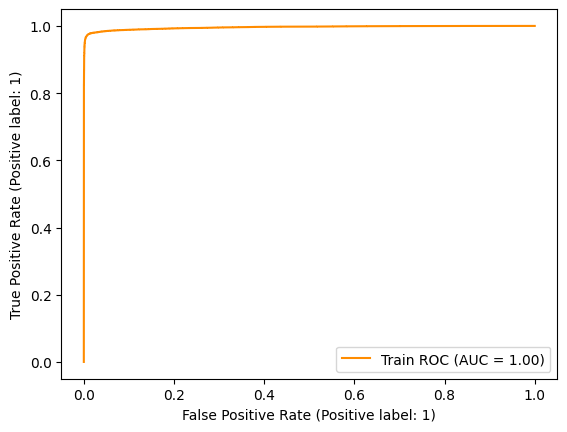

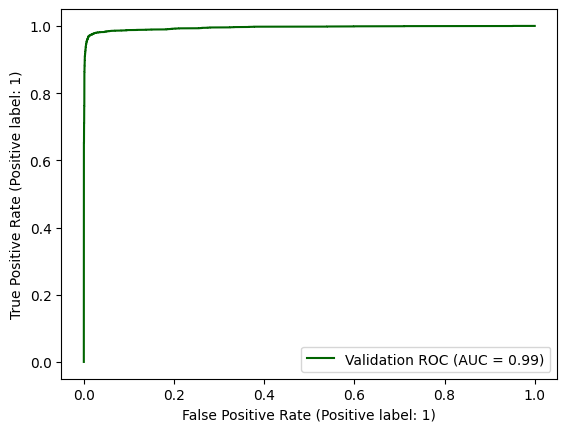

In [43]:
y_train_pred = model.predict(x_train_padded)
y_val_pred = model.predict(x_val_padded)

RocCurveDisplay.from_predictions(
    y_train_np,
    y_train_pred,
    name=f"Train ROC",
    color="darkorange"
)

RocCurveDisplay.from_predictions(
    y_val_np,
    y_val_pred,
    name=f"Validation ROC",
    color="darkgreen"
)

test data prep and evaluation

In [44]:
# test_text_processed = text_preprocess(test_essay['text'])
test_essay.loc[:, 'text'] = test_essay.loc[:, 'text'].apply(remove_chars)
x_test_seq = tk.texts_to_sequences(test_essay['text'].values)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding="post", truncating="post")

In [45]:
x_test_padded.shape

(3, 1000)

In [46]:
y_pred = model.predict(x_test_padded)
y_pred

1/1 [==============================] - 1s 513ms/step


array([[0.01455794],
       [0.01455794],
       [0.01455794]], dtype=float32)

In [47]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred]})
final_submission.to_csv('submission_kag_model2.csv', index=False)

In [ ]:
#save the model and its weights: model-2

model2.save('model2.h5')



In [48]:
daigt = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")

Test Essay Preprocessing and  Prediction 

In [49]:
daigt_human = pd.DataFrame({'text': daigt['text'], 'generated': 0})
daigt_ai = pd.DataFrame({'text': daigt['source_text'], 'generated': 1})
daigt_data = pd.concat([daigt_human, daigt_ai], ignore_index=True)
daigt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842 entries, 0 to 4841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4842 non-null   object
 1   generated  4842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [50]:
daigt_data.loc[:, 'text'] = daigt_data.loc[:, 'text'].apply(remove_chars)
daigt_text_seq = tk.texts_to_sequences(daigt_data['text'])
daigt_text_padded = pad_sequences(daigt_text_seq, maxlen=max_len, padding="post", truncating="post")
model.evaluate(daigt_text_padded, daigt_data['generated'].values)

152/152 [==============================] - 75s 495ms/step - loss: 0.6784 - accuracy: 0.8259


[0.678413987159729, 0.8258984088897705]

152/152 [==============================] - 76s 498ms/step


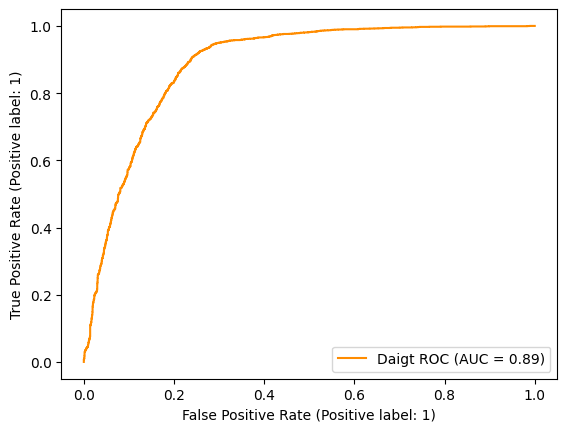

In [51]:
daigt_y_pred = model.predict(daigt_text_padded)

RocCurveDisplay.from_predictions(
    daigt_data['generated'].values,
    daigt_y_pred,
    name=f"Daigt ROC",
    color="darkorange",
)

model-3

In [65]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)




In [67]:
def simplified_lstm_attention_model(max_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(AttentionLayer())
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Create and compile the simplified model
model_simplified = simplified_lstm_attention_model(max_words, max_len)
model_simplified.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_simplified.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 300)         1800000   
                                                                 
 bidirectional_5 (Bidirecti  (None, 1000, 100)         140400    
 onal)                                                           
                                                                 
 attention_layer_1 (Attenti  (None, 100)               1100      
 onLayer)                                                        
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                

In [68]:
history = model_simplified.fit(x_train_padded, y_train_np, epochs=3, batch_size=64, 
                               validation_data=(x_val_padded, y_val_np), callbacks=[early_stopping])


Epoch 1/3
561/561 [==============================] - 112s 192ms/step - loss: 0.1901 - accuracy: 0.9597 - val_loss: 0.0441 - val_accuracy: 0.9900
Epoch 2/3
561/561 [==============================] - 62s 110ms/step - loss: 0.0999 - accuracy: 0.9703 - val_loss: 0.0562 - val_accuracy: 0.9866
Epoch 3/3
561/561 [==============================] - 58s 102ms/step - loss: 0.0345 - accuracy: 0.9936 - val_loss: 0.0416 - val_accuracy: 0.9897


In [69]:
loss, acc = model_simplified.evaluate(x_val_padded, y_val_np)

281/281 [==============================] - 7s 25ms/step - loss: 0.0416 - accuracy: 0.9897


In [70]:
model_simplified.save('simplified_lstm_attention_model')


281/281 [==============================] - 7s 23ms/step


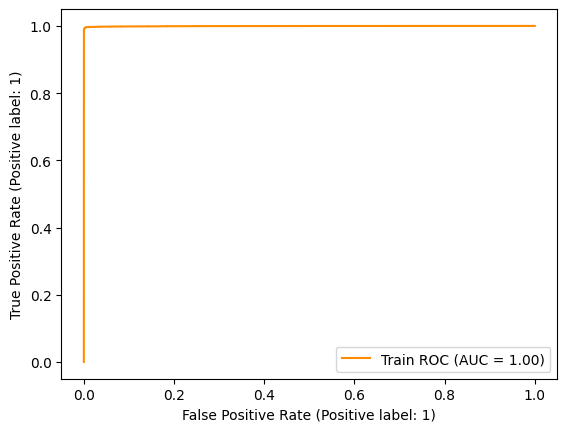

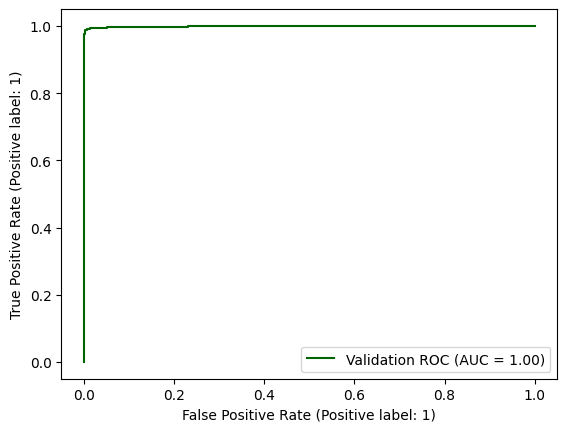

In [75]:
from tensorflow.keras.models import load_model
from sklearn.metrics import RocCurveDisplay
# Ensure that your custom AttentionLayer class is also imported here


# Or if it was saved using the SavedModel format
restored_model = load_model('simplified_lstm_attention_model', custom_objects={'AttentionLayer': AttentionLayer})


# Generate predictions
y_train_pred = restored_model.predict(x_train_padded)
y_val_pred = restored_model.predict(x_val_padded)

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_train_np, y_train_pred, name="Train ROC", color="darkorange")
RocCurveDisplay.from_predictions(y_val_np, y_val_pred, name="Validation ROC", color="darkgreen")



In [ ]:
# test_text_processed = text_preprocess(test_essay['text'])
test_essay.loc[:, 'text'] = test_essay.loc[:, 'text'].apply(remove_chars)
x_test_seq = tk.texts_to_sequences(test_essay['text'].values)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding="post", truncating="post")

In [76]:
x_test_padded.shape

(3, 1000)

In [78]:
y_pred = restored_model.predict(x_test_padded)
y_pred

1/1 [==============================] - 0s 45ms/step


array([[0.9935868],
       [0.9935868],
       [0.9935868]], dtype=float32)

In [79]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred]})
final_submission.to_csv('submission_kag_with attentionlayer.csv', index=False)

In [80]:
daigt = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")

In [81]:
daigt_human = pd.DataFrame({'text': daigt['text'], 'generated': 0})
daigt_ai = pd.DataFrame({'text': daigt['source_text'], 'generated': 1})
daigt_data = pd.concat([daigt_human, daigt_ai], ignore_index=True)
daigt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842 entries, 0 to 4841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4842 non-null   object
 1   generated  4842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [82]:
daigt_data.loc[:, 'text'] = daigt_data.loc[:, 'text'].apply(remove_chars)
daigt_text_seq = tk.texts_to_sequences(daigt_data['text'])
daigt_text_padded = pad_sequences(daigt_text_seq, maxlen=max_len, padding="post", truncating="post")
restored_model.evaluate(daigt_text_padded, daigt_data['generated'].values)

152/152 [==============================] - 5s 26ms/step - loss: 0.2714 - accuracy: 0.9108


[0.2713560163974762, 0.910780668258667]